In [1]:
import os

import numpy as np
import matplotlib.pyplot as plt
from matplotlib.gridspec import GridSpec
import seaborn as sns

import torch
import torch.nn as nn
import torchvision

from time import sleep, time
from sklearn.model_selection import train_test_split
from sklearn.utils import shuffle

In [2]:
# from jupyterthemes import jtplot
# jtplot.style()
# jtplot.style(theme='solarizedd')
# jtplot.style(context='paper', fscale=1.4, spines=False, gridlines='--')
# jtplot.style(ticks=True, grid=False, figsize=(6, 4.5))

In [3]:
DATASET_FOLDER_PATH = '/Users/aref/dvs-dataset/DvsGesture'

nb_image_height = 64
nb_image_weight = 64
nb_inputs  = nb_image_height*nb_image_weight
nb_hidden  = 128
nb_outputs = 12

time_step = 1e-3
nb_steps  = 100

batch_size = 16

In [4]:
dtype = torch.float

# Check whether a GPU is available
if torch.cuda.is_available():
    print('using cuda...')
    device = torch.device("cuda")     
else:
    print('using cpu...')
    device = torch.device("cpu")

using cpu...


In [5]:
# Load file list:
train_trail_file = 'trials_to_train.txt'
test_trail_file = 'trials_to_test.txt'

def load_trail_files(trail_file):
    file_list = []
    with open(os.path.join(DATASET_FOLDER_PATH, trail_file), 'r') as f:
        for line in f.readlines():
            aedat_file = line.strip()
            if not line:
                continue
            csv_file = aedat_file.replace('.aedat', '_labels.csv')
            file_list.append((
                os.path.join(DATASET_FOLDER_PATH, aedat_file),
                os.path.join(DATASET_FOLDER_PATH, csv_file)
            ))
    return file_list

file_list_train = load_trail_files(train_trail_file)
file_list_test = load_trail_files(test_trail_file)

def get_label(event_labels, timestamp):
    for t in event_labels.keys():
        if t > timestamp:
            return event_labels[t]
    return 0

def get_label_text(event_labels, timestamp):
    return gesture_mapping[get_label(event_labels, timestamp)]

# mapping
gesture_mapping = {
    0: 'no_gesture',
    1: 'hand_clapping',
    2: 'right_hand_wave',
    3: 'left_hand_wave',
    4: 'right_arm_clockwise',
    5: 'right_arm_counter_clockwise',
    6: 'left_arm_clockwise',
    7: 'left_arm_counter_clockwise',
    8: 'arm_roll',
    9: 'air_drums',
    10: 'air_guitar',
    11: 'other_gestures',
}

In [6]:
from time import time
from datetime import datetime

_last_time_length = None
_iteration_left = None

def time_unit_creator(l_time):
    time_unit = 'seconds'
    if l_time >= 60:
        l_time /= 60
        time_unit = 'minutes'
    else:
        return l_time, time_unit
    
    if l_time >= 60:
        l_time /= 60
        time_unit = 'hours'
    else:
        return l_time, time_unit
    
    if l_time >= 24:
        l_time /= 24
        time_unit = 'days'
    else:
        return l_time, time_unit
        
    if l_time >= 30:
        l_time /= 30
        time_unit = 'month'
    else:
        return l_time, time_unit

def expector_timer(func):
    def wrapper(*args, **kwargs):
        global _last_time_length, _iteration_left
        t_start = time()
        
        if _last_time_length is not None:
            expectation = t_start
            if _iteration_left is not None:
                expectation +=  _last_time_length * _iteration_left
            else:
                expectation +=  _last_time_length
            datestr = datetime.fromtimestamp(expectation).strftime("%Y-%m-%d %H:%M:%S")
            print '[expecting to finish at %s]' % datestr
        res = func(*args, **kwargs)
        length = time() - t_start
        
        if _last_time_length is None:
            _last_time_length = length
        else:
            _last_time_length = .9 * _last_time_length + .1 * length
        
        length, length_unit = time_unit_creator(length)
        print '[operation finished at %s  -  took %d %s]' % (datetime.fromtimestamp(time()).strftime("%Y-%m-%d %H:%M:%S"), length, length_unit)
        
        return res
    return wrapper

In [7]:
# Data Reader

import struct
from collections import OrderedDict

DEBUG_PRINT = False

class EOF(Exception):
    pass


def read_file(f, size, unpack_type=None):
    d = f.read(size)
    if d == '':
        raise EOF()
    if unpack_type is None:
        unpack_type = 'H' if size == 2 else 'I'
    return struct.unpack(unpack_type, d)[0]


def skip_file_header(f):
    line_counter = 0
    line = '#'
    while line.startswith('#') and not line.startswith('#!END-HEADER'):
        line = f.readline()


def read_header(f):
    header = OrderedDict([
        ('eventType', read_file(f, 2)),
        ('eventSource', read_file(f, 2)),
        ('eventSize', read_file(f, 4)),
        ('eventTSOffset', read_file(f, 4)),
        ('eventTSOverflow', read_file(f, 4)),
        ('eventCapacity', read_file(f, 4)),
        ('eventNumber', read_file(f, 4)),
        ('eventValid', read_file(f, 4)),
    ])
    return header


def read_event(f, timestamp_offset):
    data = read_file(f, 4)
    timestamp = read_file(f, 4, 'i')
    x = ( data >> 17 ) & 0x00001FFF
    y = ( data >> 2 ) & 0x00001FFF
    polarity = ( data >> 1 ) & 0x00000001
    return {
        'x': x,
        'y': y,
        'polarity': polarity,
        'timestamp': timestamp + timestamp_offset * 2**31,
        'data': data,
    }


def load_dataset(file_path):
    event_list = []
    with open(file_path, 'rb') as f:
        skip_file_header(f)
        
        while True:
            try:
                header = read_header(f)
                if DEBUG_PRINT:
                    for k, v in header.items():
                        print('%15s:  %d' % (k, v))
                    print('--------------------------')

                event_number = header['eventNumber']
                for i in range(event_number):
                    event = read_event(f, header['eventTSOffset'])
                    event_list.append(event)
                event_list.append('clear')
            except EOF:
                break
    return event_list

def read_file_all(file_name):
    if DEBUG_PRINT:
        print('loading dataset...')
    event_list = load_dataset(file_name)
    if DEBUG_PRINT:
        print('done!')
    return event_list


In [8]:
from collections import OrderedDict

def read_event_labels(path):
    label_began_time = None
    event_labels = OrderedDict()
    with open(path, 'r') as f:
        for line in f.readlines():
            label, start, end = line.strip().split(',')
#             print '%5s\t%15s\t%15s' % (label, start, end)
            try:
                label = int(label)
                start = int(start)
                end = int(end)
            except ValueError:
                continue
            if label_began_time is None:
                label_began_time = start

            event_labels[start] = 0
            event_labels[end] = label
    return event_labels, label_began_time


max_count = 0
def cache_trail_set_from_file_list(trail, file_list):
    counter = 0
    for file_name_set in file_list:
        x_train = np.zeros([0, 100, nb_inputs])
        y_train = []
        
        light_condition = file_name_set[0].split('/')[-1].split('.')[0][len('userXX_'):]
        if light_condition not in ['natural']:
            continue
        
        counter += 1
        max_count = counter+1
        
        print '%d out of %d ----------------------------------------------------------' % (counter, len(file_list))
        print '    reading "%s"' % file_name_set[0]
        event_labels, label_began_time = read_event_labels(file_name_set[1])
        event_list = read_file_all(file_name_set[0])

        print('    processing file')
        img = np.zeros([nb_image_weight, nb_image_height])

        max_time = None
        min_time = None
        begin_time = None
        end_time = None

        prev_label = None
        frame_counter = 0
        for frame_offset in [0, 50]:
            offset_counter = frame_offset
            x_frame = np.zeros([1, 100, nb_inputs])
            for e in event_list:
                if e != 'clear':
                    img[int(e['y']/2), int(e['x']/2)] = 1 # if e['polarity'] == 1 else 0
                    if e['timestamp'] < min_time or min_time is None:
                        min_time = e['timestamp']
                    if e['timestamp'] > max_time or max_time is None:
                        max_time = e['timestamp']
                else:
                    if begin_time is None:
                        begin_time = min_time
                    end_time = max_time
                    
                    if offset_counter > 0:
                        offset_counter -= 1
                        continue
                    
                    mean_time = (max_time + min_time)/2
                    mean_time = mean_time - begin_time + label_began_time
                    label = get_label(event_labels, mean_time)
                    max_time = None
                    min_time = None
                    if prev_label is None:
                        prev_label = label
                    elif prev_label != label:
                        prev_label = None
                        x_frame = np.zeros([1, 100, nb_inputs])
                        img = np.zeros([nb_image_weight, nb_image_height])
                        frame_counter = 0
                        offset_counter = frame_offset
                        continue

                    if frame_counter == 100:
                        y_train.append(label)
                        x_train = np.append(x_train, x_frame, axis=0)
                        x_frame = np.zeros([1, 100, nb_inputs])
                        frame_counter = 0
                    else:
                        x_frame[0, frame_counter, :] = img.flatten()
                        frame_counter += 1
                    img = np.zeros([nb_image_weight, nb_image_height])

        x_train = np.array(x_train, dtype='uint8')
        y_train = np.array(y_train, dtype='uint8')
        np.save(file="t_cache/x_%s_cache_%d" % (trail, counter), arr=x_train)
        np.save(file="t_cache/y_%s_cache_%d" % (trail, counter), arr=y_train)
        print '    saved!'
        
# cache_trail_set_from_file_list('train', file_list_train)
# cache_trail_set_from_file_list('test', file_list_test)

In [9]:
def from_cache_generator_1(train_set=True):
    counter = 0
#     file_list = file_list_train if train_set else file_list_test
    file_list_count = 16 if train_set else 4
    for file_name_set in range(file_list_count):
        counter += 1
        x_train = np.load(file="t_cache/x_train_cache_%d.npy" % counter)
        y_train = np.load(file="t_cache/y_train_cache_%d.npy" % counter)
        
        if dont_select_zero:
            select_id = y_train != 0
            yield shuffle(x_train[select_id], y_train[select_id])
        else:
            yield shuffle(x_train, y_train)

In [10]:
# New data fetching:
from random import randint

def load_trail_files(trail_file):
    DATASET_FOLDER_PATH = "/Users/aref/dvs-dataset/"
    file_list = []
    with open(os.path.join(DATASET_FOLDER_PATH, 'DvsGesture', trail_file), 'r') as f:
        for line in f.readlines():
            aedat_file = line.strip()
            if not line:
                continue
            csv_file = aedat_file.replace('.aedat', '_labels.csv')
            file_list.append((
                os.path.join(DATASET_FOLDER_PATH, aedat_file),
                os.path.join(DATASET_FOLDER_PATH, csv_file)
            ))
    return file_list

def data_loader(trail, condition_limit=None):
    DATASET_FOLDER_PATH = "/Users/aref/dvs-dataset/"
    dataset_path = DATASET_FOLDER_PATH + 'cleaned_cache_' + trail
    file_list = load_trail_files('trials_to_%s.txt' % trail)

    
    for counter, f in enumerate(file_list):
        # FIXME: This line is not satisfactory...
        light_condition = f[0].split('/')[-1].split('.')[0][len('userXX_'):]
        if condition_limit is not None and light_condition not in condition_limit:
            continue
        
        x_data = np.load(file='%s/x_%s_%d.npy' % (dataset_path, trail, counter+1))
        y_data = np.load(file='%s/y_%s_%d.npy' % (dataset_path, trail, counter+1))
        
        yield x_data, y_data

def serialize_events(x_data, y_data, shuffle_augmentation=None, sequential_augmentation=True):
    total_data_frame_count = x_data.shape[0]
    
    x_batch = []
    y_batch = []
    
    x_instance = []
    y_instance = None
    
    if sequential_augmentation:
        for i in range(total_data_frame_count):
            x_instance.append(x_data[i, ...])
            if y_instance is None:
                y_instance = y_data[i]
            elif y_instance != y_data[i]:
                x_instance = []
                y_instance = None
                continue

            if len(x_instance) == nb_steps and y_instance != 0:
                x_batch.append(np.array(x_instance))
                y_batch.append(y_instance)

                x_instance = []
                y_instance = None

                if len(x_batch) == batch_size:
                    yield np.array(x_batch), np.array(y_batch)
                    x_batch = []
                    y_batch = []

    if shuffle_augmentation is not None:
        x_instance = []
        y_instance = None

        augmented_batchs = 0
        while augmented_batchs < shuffle_augmentation:
            start = randint(0, total_data_frame_count-nb_steps-1)
            
            for i in range(start, start+nb_steps):
                x_instance.append(x_data[i, ...])
                if y_instance is None:
                    y_instance = y_data[i]
                elif y_instance != y_data[i]:
                    break
            
            if len(x_instance) == nb_steps and y_instance != 0:
                x_batch.append(np.array(x_instance))
                y_batch.append(y_instance)

                if len(x_batch) == batch_size:
                    augmented_batchs += 1
                    yield np.array(x_batch), np.array(y_batch)
                    x_batch = []
                    y_batch = []
            
            x_instance = []
            y_instance = None
            
            
def from_cache_generator_2(train_set=True):
    for x_data, y_data in data_loader('train' if train_set else 'test', condition_limit=['natural']):
        for x_local, y_local in serialize_events(x_data, y_data):
            if dont_select_zero:
                select_id = y_local != 0
                yield x_local[select_id], y_local[select_id]
            else:
                yield x_local, y_local

In [11]:
def from_cache_generator(train_set=True):
    if USE_GEN_2:
        return from_cache_generator_2(train_set)
    else:
        return from_cache_generator_1(train_set)

In [12]:
tau_mem = 10e-3
tau_syn = 5e-3

alpha   = float(np.exp(-time_step/tau_syn))
beta    = float(np.exp(-time_step/tau_mem))

In [13]:
def init_all():
    global w1, w2, loss_hist, loss_hist_test, hmap, hmap_test
    weight_scale = 7*(1.0-beta) # this should give us some spikes to begin with

    w1 = torch.empty((nb_inputs+1, nb_hidden),  device=device, dtype=dtype, requires_grad=True)
    torch.nn.init.normal_(w1, mean=0.0, std=weight_scale/np.sqrt(nb_inputs))

    w2 = torch.empty((nb_hidden, nb_outputs), device=device, dtype=dtype, requires_grad=True)
    torch.nn.init.normal_(w2, mean=0.0, std=weight_scale/np.sqrt(nb_hidden))

    loss_hist = []
    loss_hist_test = []

    hmap = np.zeros((nb_outputs, nb_outputs))
    hmap_test = np.zeros((nb_outputs, nb_outputs))

    print('init')

In [14]:
class SuperSpike(torch.autograd.Function):
    scale = 50.0 # controls steepness of surrogate gradient

    @staticmethod
    def forward(ctx, input):
        ctx.save_for_backward(input)
        out = torch.zeros_like(input)
        out[input > 0] = 1.0
        return out

    @staticmethod
    def backward(ctx, grad_output):
        input, = ctx.saved_tensors
        grad_input = grad_output.clone()
        return grad_input/(SuperSpike.scale*torch.abs(input)+1.0)**2
#         return grad_input
    
spike_fn  = SuperSpike.apply

In [15]:
def run_snn(inputs):
#     h1 = torch.einsum("abc,cd->abd", (inputs, w1))
    h1 = torch.einsum("abc,cd->abd", (inputs, w1[:-1]))
    hr = torch.zeros((batch_size,nb_hidden), device=device, dtype=dtype)
    syn = torch.zeros((batch_size,nb_hidden), device=device, dtype=dtype)
    mem = torch.zeros((batch_size,nb_hidden), device=device, dtype=dtype)

    mem_rec = [mem]
    spk_rec = [mem]

    # Compute hidden layer activity
    for t in range(nb_steps):
        mthr = mem-1.0
        out = spike_fn(mthr)
        rst = torch.zeros_like(mem)
        c   = (mthr > 0)
        rst[c] = torch.ones_like(mem)[c]
       
        rs =  torch.ones_like(mem)
        for i in range(batch_size):
            rs[i,:] = w1[-1, :]
        rs[mthr <= 0] = 0
        
        new_syn = alpha*syn +h1[:,t] +rs
        new_mem = beta*mem +syn -rst

        mem = new_mem
        syn = new_syn

        mem_rec.append(mem)
        spk_rec.append(out)

    mem_rec = torch.stack(mem_rec,dim=1)
    spk_rec = torch.stack(spk_rec,dim=1)

    # Readout layer
    h2= torch.einsum("abc,cd->abd", (spk_rec, w2))
    flt = torch.zeros((batch_size,nb_outputs), device=device, dtype=dtype)
    out = torch.zeros((batch_size,nb_outputs), device=device, dtype=dtype)
    out_rec = [out]
    for t in range(nb_steps):
#         rs = torch.ones_like(out)
#         for i in range(batch_size):
#             rs[i,:] = w2[-1, :]
#         rs[out <= 0] = 0
        
        new_flt = alpha*flt +h2[:,t] #+rs
        new_out = beta*out +flt

        flt = new_flt
        out = new_out

        out_rec.append(out)

    out_rec = torch.stack(out_rec,dim=1)
    other_recs = [mem_rec, spk_rec]
    return out_rec, other_recs

In [16]:
from random import random

def train(lr=2e-3, nb_epochs=10, loss_hist=None):
    params = [w1,w2]
    optimizer = torch.optim.Adam(params, lr=lr, betas=(0.9,0.999))

    log_softmax_fn = nn.LogSoftmax(dim=1)
    loss_fn = nn.NLLLoss()
    
    if loss_hist is None:
        loss_hist = []
    for e in range(nb_epochs):
        print_counter = 0
        local_loss = []
        test_local_loss = []
        for x_data, y_data in from_cache_generator():
            if print_counter % 4 == 0:
                print '.',
            print_counter += 1
            
            y_data = y_data.astype(np.long)
            max_count = x_data.shape[0] / batch_size
            for counter in range(max_count):
                i = counter*batch_size
                x_local = torch.from_numpy(x_data[i:i+batch_size, :, :]).type(dtype)
                y_local = torch.from_numpy(y_data[i:i+batch_size])

                if x_local.shape[0] != batch_size:
                    print '                     skipping', x_local.shape
                    continue
#                 print 'using', x_local.shape

#                 print '>>> test_x: ', x_local.shape
#                 print '>>> test_y: ', y_local.shape
                    
                
                output,_ = run_snn(x_local)
                m,_=torch.max(output,1)
                log_p_y = log_softmax_fn(m)
                loss_val = loss_fn(log_p_y, y_local)

                optimizer.zero_grad()
                loss_val.backward()
                optimizer.step()
                local_loss.append(loss_val.item())
                
        # this part is about drawing test plot
        for x_data, y_data in from_cache_generator(False):
            y_data = y_data.astype(np.long)
            max_count = x_data.shape[0] / batch_size
            for counter in range(max_count):
                i = counter*batch_size
                x_local = torch.from_numpy(x_data[i:i+batch_size, :, :]).type(dtype)
                y_local = torch.from_numpy(y_data[i:i+batch_size])
                
                if x_local.shape[0] != batch_size:
                    print '               (T) skipping', x_local.shape
                    continue
#                 print 'using', x_local.shape
                
#                 print '>>> test_x: ', x_local.shape
#                 print '>>> test_y: ', y_local.shape
                
                
                output,_ = run_snn(x_local)
                m,_=torch.max(output,1)
                log_p_y = log_softmax_fn(m)
                loss_val = loss_fn(log_p_y, y_local)
                test_local_loss.append(loss_val.item())
                
                
        mean_loss = np.mean(local_loss)
        loss_hist.append(mean_loss)
        print("Epoch %i: loss=%.5f"%(e+1,mean_loss))
        
        mean_loss = np.mean(test_local_loss)
        loss_hist_test.append(mean_loss)
    return loss_hist


In [17]:
def compute_classification_accuracy(x_data, y_data, is_test=False):
    """ Computes classification accuracy on supplied data in batches. """
    accs = []
    max_count = len(x_data) / batch_size
    for counter in range(max_count):
        i = counter*batch_size
        x_local = torch.from_numpy(x_data[i:i+batch_size, :, :]).type(dtype)
        y_local = torch.from_numpy(y_data[i:i+batch_size])
        output, _ = run_snn(x_local)
        m, _ = torch.max(output,1) # max over time
        _, am = torch.max(m,1)      # argmax over output units
        tmp = np.mean((y_local.type(torch.long)==am).detach().cpu().numpy()) # compare to labels
        
        for i in range(y_local.shape[0]):
            if is_test:
                hmap_test[y_local[i], am[i]] += 1
            else:
                hmap[y_local[i], am[i]] += 1
        accs.append(tmp)
    return np.mean(accs)


In [18]:
def print_accuracy_values():
    errors = []
    for x_data, y_data in from_cache_generator():
        errors.append(compute_classification_accuracy(x_data, y_data, False))
    print("Train accuracy: %.3f" % (np.mean(np.array(errors))))

    errors = []
    for x_data, y_data in from_cache_generator(False):
        errors.append(compute_classification_accuracy(x_data, y_data, True))
    print("Test accuracy: %.3f" % (np.mean(np.array(errors))))

In [19]:
%matplotlib inline
def train_once():
    global loss_hist, hmap, hmap_test
    loss_hist = train(lr=2e-4, nb_epochs=5, loss_hist=loss_hist)

    plt.figure(figsize=(3.3,2),dpi=150)
    plt.plot(loss_hist)
    plt.plot(loss_hist_test, 'r--')
    plt.xlabel("Epoch")
    plt.ylabel("Loss")
    plt.show()
    sns.despine()
    print_accuracy_values()
    
    sns.heatmap(hmap)
    plt.show()
    sns.heatmap(hmap_test)
    plt.show()
    hmap = np.zeros((nb_outputs, nb_outputs))
    hmap_test = np.zeros((nb_outputs, nb_outputs))
    
#     np.save(file="_checkpoint_%d" % time(), arr=[w1, w2])
    print('[check point saved.]')

 init
. . . . Epoch 1: loss=2.42655
. . . . Epoch 2: loss=1.82675
. . . . Epoch 3: loss=1.64097
. . . . Epoch 4: loss=1.54157
. . . . Epoch 5: loss=1.47597


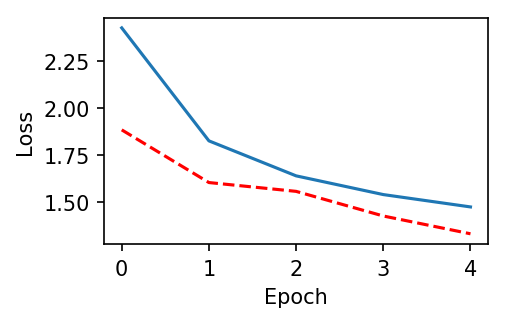

Train accuracy: 0.484
Test accuracy: 0.549


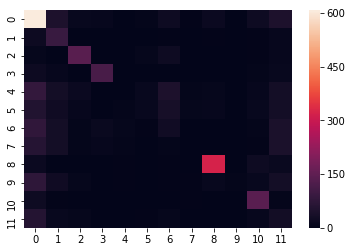

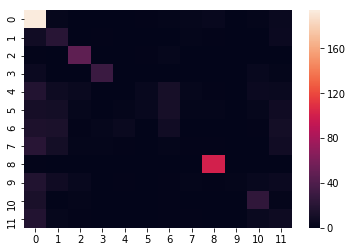

[check point saved.]
. . . . Epoch 1: loss=1.52459
. . . . Epoch 2: loss=1.47636
. . . . Epoch 3: loss=1.41122
. . . . Epoch 4: loss=1.39688
. . . . Epoch 5: loss=1.29408


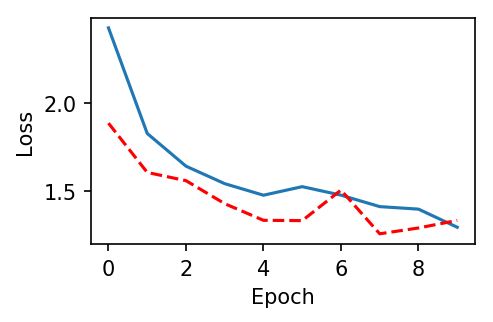

Train accuracy: 0.578
Test accuracy: 0.580


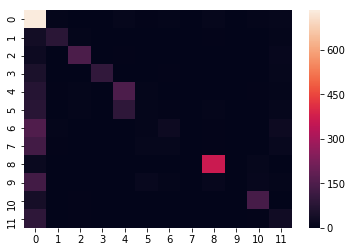

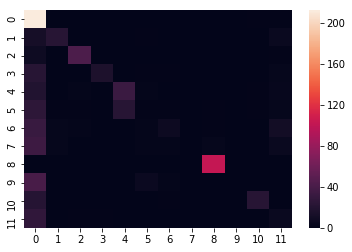

[check point saved.]
. . . . Epoch 1: loss=1.24634
. . . . Epoch 2: loss=1.22379
. . . . Epoch 3: loss=1.17120
. . . . Epoch 4: loss=1.12471
. . . . Epoch 5: loss=1.05722


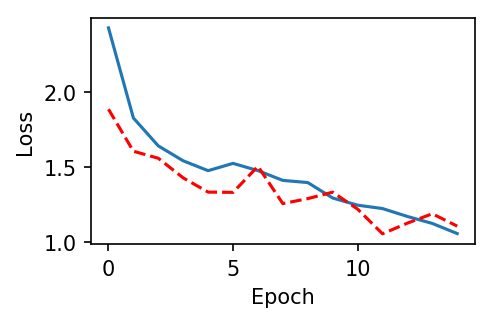

Train accuracy: 0.680
Test accuracy: 0.678


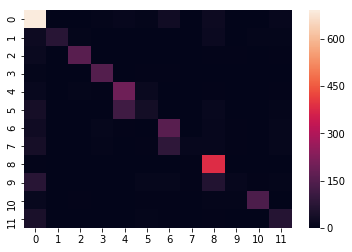

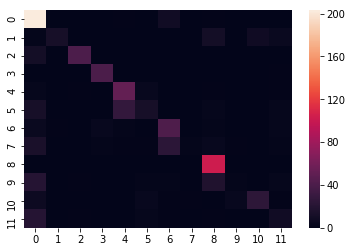

[check point saved.]
. . . . Epoch 1: loss=0.97161
. . . . Epoch 2: loss=0.92141
. . . . Epoch 3: loss=0.89466
. . . . Epoch 4: loss=0.82126
. . . . Epoch 5: loss=0.75424


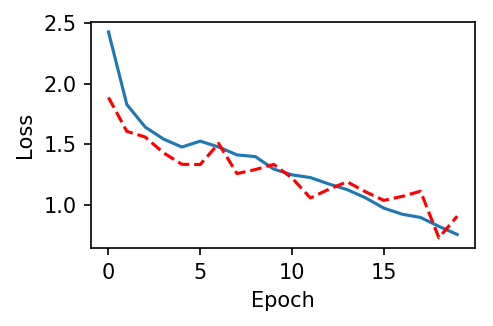

Train accuracy: 0.751
Test accuracy: 0.760


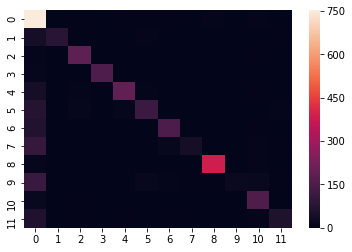

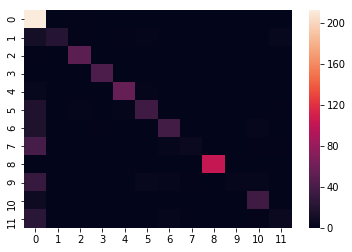

[check point saved.]
. . . . Epoch 1: loss=0.68142
. . . . Epoch 2: loss=0.67669
. . . . Epoch 3: loss=0.56647
. . . . Epoch 4: loss=0.58509
. . . . Epoch 5: loss=0.54909


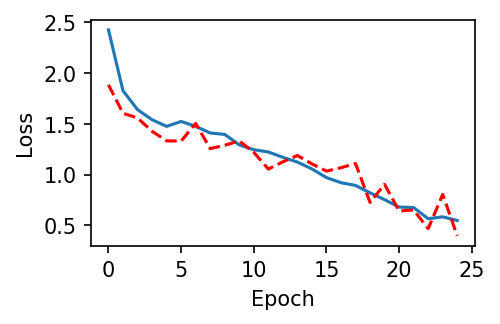

Train accuracy: 0.848
Test accuracy: 0.870


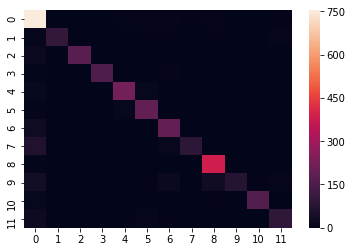

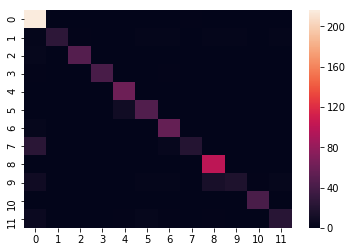

[check point saved.]
. . . . Epoch 1: loss=0.47749
. . . . Epoch 2: loss=0.37546
. . . . Epoch 3: loss=0.39553
. . . . Epoch 4: loss=0.38004
. . . . Epoch 5: loss=0.33261


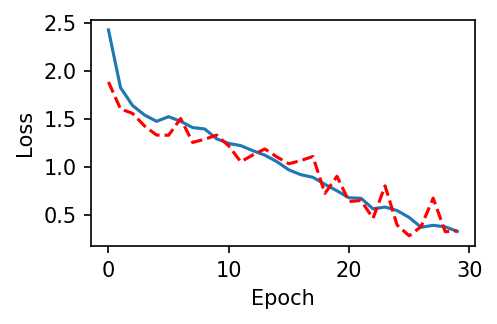

Train accuracy: 0.895
Test accuracy: 0.914


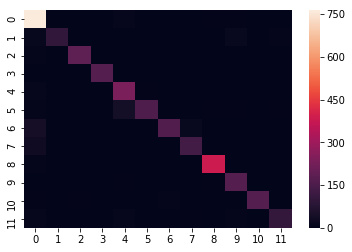

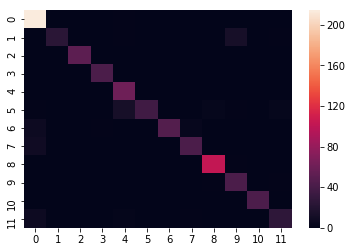

[check point saved.]
. . . . Epoch 1: loss=0.35021
. . . . Epoch 2: loss=0.31636
. . . . Epoch 3: loss=0.31271
. . . . Epoch 4: loss=0.28881
. . . . Epoch 5: loss=0.26109


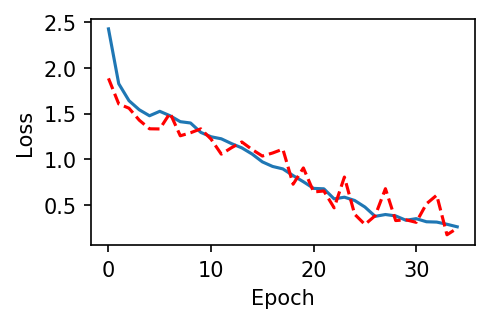

Train accuracy: 0.920
Test accuracy: 0.931


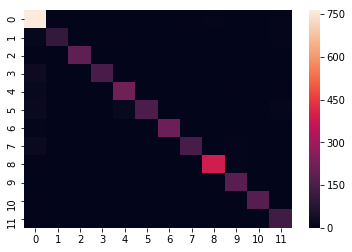

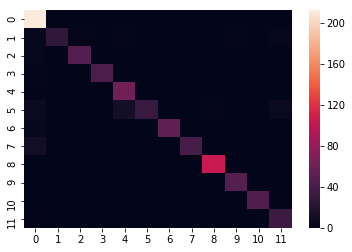

[check point saved.]
. . . . Epoch 1: loss=0.26300
. . . . Epoch 2: loss=0.22945
. . . . Epoch 3: loss=0.30060
. . . . Epoch 4: loss=0.27253
. . . . Epoch 5: loss=0.20349


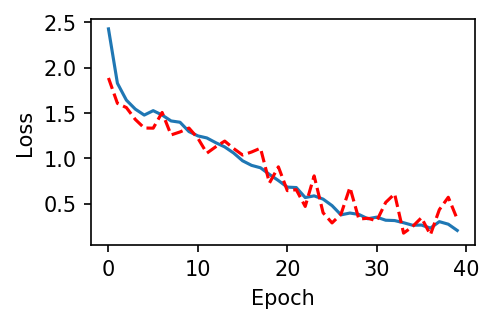

Train accuracy: 0.895
Test accuracy: 0.896


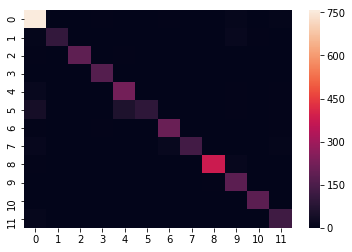

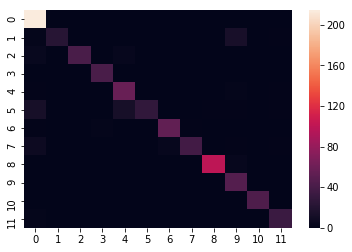

[check point saved.]
. . . . Epoch 1: loss=0.25209
. . . . Epoch 2: loss=0.17942
. . . . Epoch 3: loss=0.14197
. . . . Epoch 4: loss=0.13800
. . . . Epoch 5: loss=0.15134


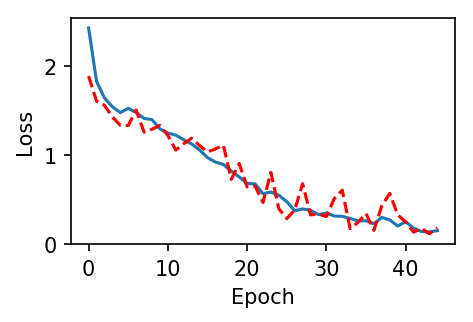

Train accuracy: 0.939
Test accuracy: 0.946


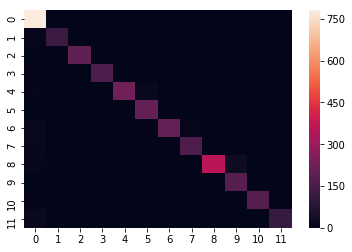

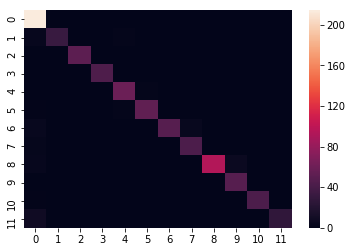

[check point saved.]
. . . . Epoch 1: loss=0.21150
. . . . Epoch 2: loss=0.22992
. . . . Epoch 3: loss=0.20366
. . . . Epoch 4: loss=0.15732
. . . . Epoch 5: loss=0.12528


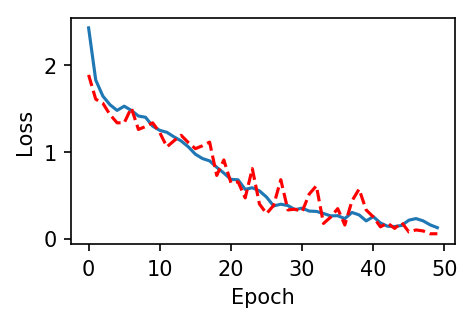

Train accuracy: 0.962
Test accuracy: 0.989


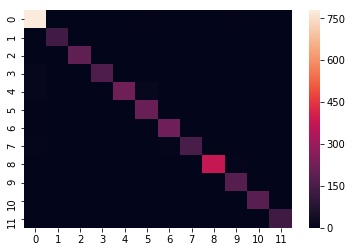

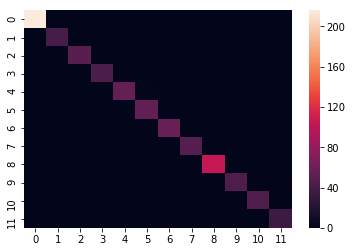

[check point saved.]


In [21]:
USE_GEN_2 = False
init_all()
dont_select_zero = False
for _ in range(10):
    train_once()

In [ ]:
# USE_GEN_2 = False
# init_all()
# dont_select_zero = True
# for _ in range(10):
#     train_once()

In [ ]:
# USE_GEN_2 = True
# init_all()
# dont_select_zero = True
# for _ in range(10):
#     train_once()

In [ ]:
# %matplotlib inline

# USE_GEN_2 = True
# for x_data, y_data in from_cache_generator():
#     img = np.reshape(x_data[0, 0, :], (64, 64))
#     plt.imshow(img)
#     plt.show()
#     break

# USE_GEN_2 = False
# for x_data, y_data in from_cache_generator():
#     img = np.reshape(x_data[0, 0, :], (64, 64))
#     plt.imshow(img)
#     plt.show()
#     break